# WMT Budget 
## (using ERA5 | GLORYS | MATT's model)

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram

In [2]:
sst_ds1 = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
sst_ds = sst_ds1.assign_coords({'longitude':(sst_ds1.longitude.values-360)})
#mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
heat_fluxes_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})
heat_fluxes = heat_fluxes_ds.assign_coords({'longitude':(heat_fluxes_ds.longitude.values-360)})
glorys = xr.open_dataset('sst_glorys.nc', chunks={})

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [3]:
heat_fluxes

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 55, time: 10408, longitude: 69)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

In [4]:
glorys

<xarray.Dataset> Size: 232GB
Dimensions:    (depth: 49, latitude: 169, longitude: 337, time: 10408)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 676B 17.0 17.08 17.17 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 1kB -100.0 -99.92 -99.83 ... -72.08 -72.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 232GB dask.array<chunksize=(10408, 49, 169, 337), meta=np.ndarray>
Attributes:
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    source:       MERCATOR GLORYS12V1
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr
    institution:  MERCATOR OCEAN

# 1) Process budget variables 
(to desired spatial/grid and temporal configuration)

In [26]:
time_slice = dict(time=slice('1993', '2021-06-30'))
gom = dict(longitude=slice(-98, -81), latitude=slice(17.5, 31))

sst_g = glorys.thetao.sel(**gom)
sst = sst_ds.sea_surface_temperature.sel(**time_slice).resample(time='D').mean()
#mask = mask_ds.land_sea_mask

sw = heat_fluxes.ssr.sel(**time_slice) / (60*60) #W/m2
lw = heat_fluxes.str.sel(**time_slice) / (60*60) #W/m2
sh = heat_fluxes.sshf.sel(**time_slice) / (60*60) #W/m2
lh = heat_fluxes.slhf.sel(**time_slice) / (60*60) #W/m2

hf = xr.merge([sw,lw,sh,lh])

In [27]:
hf

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 55, time: 10408, longitude: 69)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>

In [6]:
sst

<xarray.DataArray 'sea_surface_temperature' (time: 10408, latitude: 55,
                                             longitude: 69)> Size: 158MB
dask.array<transpose, shape=(10408, 55, 69), dtype=float32, chunksize=(10408, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [7]:
sst_g

<xarray.DataArray 'thetao' (time: 10408, depth: 49, latitude: 163,
                            longitude: 205)> Size: 136GB
dask.array<getitem, shape=(10408, 49, 163, 205), dtype=float64, chunksize=(10408, 49, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Attributes:
    long_name:      Temperature
    unit_long:      Degrees Celsius
    standard_name:  sea_water_potential_temperature
    valid_min:      -32766
    valid_max:      21306
    units:          degrees_C

In [8]:
#daily clim
clim = sst.groupby('time.dayofyear').mean('time')
clim_g = sst_g.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst.groupby('time.dayofyear') - clim
anom_g = sst_g.groupby('time.dayofyear') - clim_g

#monthly clim
mo_clim = sst.groupby('time.month').mean('time')
mo_clim_g = sst_g.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst.groupby('time.month') - mo_clim
mo_anom = sst_g.groupby('time.month') - mo_clim_g

In [9]:
# Find 90th, 95th, 99th percentile temperatures
q99 = sst.quantile(0.99, dim='time')
q95 = sst.quantile(0.95, dim='time')
q90 = sst.quantile(0.90, dim='time')

q99_g = sst_g.isel(depth=0).quantile(0.99, dim='time')
q95_g = sst_g.isel(depth=0).quantile(0.95, dim='time')
q90_g = sst_g.isel(depth=0).quantile(0.90, dim='time')

In [10]:
mask_g = sst_g[0,0].isnull()

In [11]:
mask_g

<xarray.DataArray 'thetao' (latitude: 163, longitude: 205)> Size: 33kB
dask.array<isnan, shape=(163, 205), dtype=bool, chunksize=(163, 205), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 4B 0.494
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
    time       datetime64[ns] 8B 1993-01-01

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


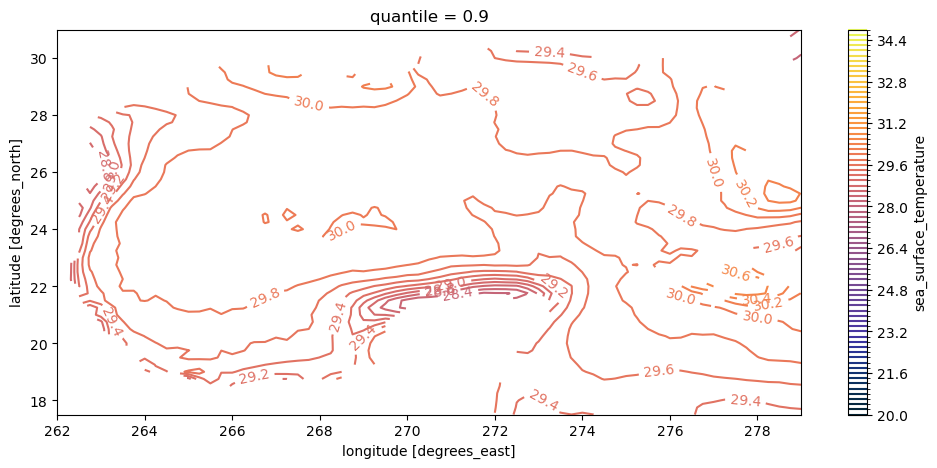

In [12]:
theta_levs = np.arange(20,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

In [14]:
# Define isotherm values to represent the MHW
isotherm = 29.4

# 2) Compute LHS ($\frac{\partial V}{\partial t}$)
(but not really dVdt)

## Create grid and area objects

### GLORYS

In [8]:
ds_pt_full = generate_grid_ds(glorys.sel(**gom), {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

NameError: name 'glorys' is not defined

In [9]:
ds_pt_full

NameError: name 'ds_pt_full' is not defined

In [11]:
grid_pt_full

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
Z Axis (not periodic, boundary=None):
  * center   depth
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center

In [12]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [13]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


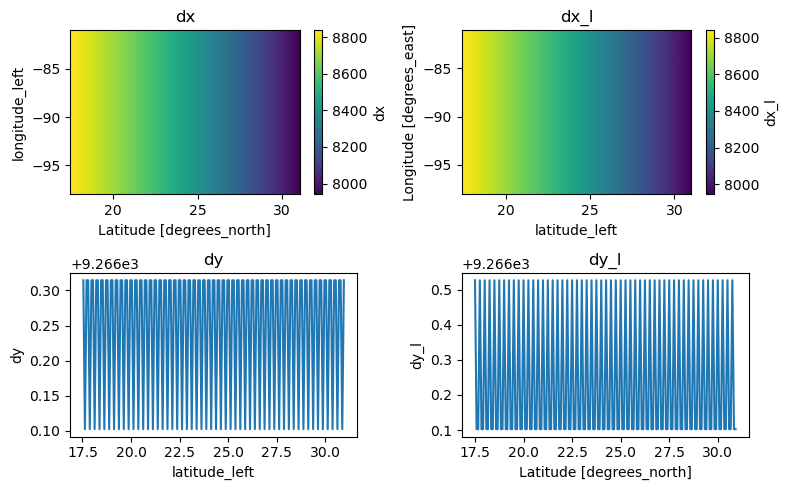

In [14]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

### `dVdt` using `.where(thetao>=isotherm)`

In [59]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = sst_g.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
masked_vol = vol.where(sst_g[:,1:,:,:-1]>=isotherm) #m^3
vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
M = vol_tot * 1034 #kg
V = M / 1034 #m^3

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [23]:
V.load()

<xarray.DataArray (time: 10408)> Size: 42kB
array([5.9195208e+09, 4.4315489e+09, 4.4315489e+09, ..., 1.8408918e+12,
       1.1588846e+12, 8.7037732e+11], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [60]:
dt_values = (np.diff(V.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], V.time.values[1:])})

dVdt = V.diff('time', label='upper') / dt #m^3/s

In [25]:
dVdt

<xarray.DataArray (time: 10407)> Size: 42kB
array([  -17221.896,        0.   ,        0.   , ..., -2794679.5  ,
       -7893602.   , -3339204.8  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 83kB 1993-01-02 1993-01-03 ... 2021-06-30

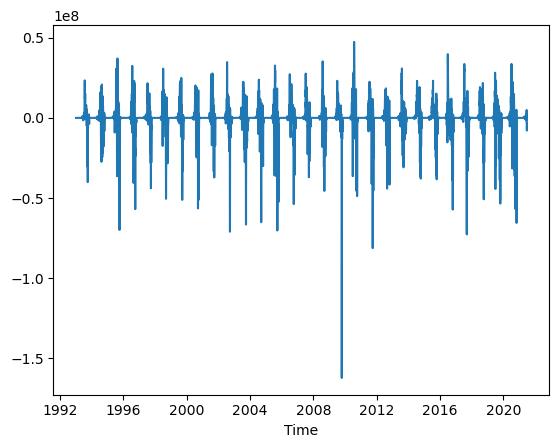

In [26]:
dVdt.plot()

### `dVdt` using `histogram(thetao, weights=vol)`

In [15]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = sst_g.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
#masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :, :-1]>=31.8) #m^3
#vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
#M = vol_tot * 1034 #kg
#V = M / 1034 #m^3

#expanded tbin range to include colder temps because cumsum method wasn't matching with other dvdt definitions
delta_theta = 0.1
theta_bins = np.arange(0, 35, delta_theta)

tdist = histogram(sst_g[:,1:,:,:-1].rename('theta'), bins=[theta_bins],
                  weights=vol, dim=['latitude', 'longitude', 'depth']) #˚C m^3

V = tdist.isel(theta_bin=slice(None, None, -1)).cumsum(dim='theta_bin')

In [16]:
tdist

<xarray.DataArray 'histogram_theta' (time: 10408, theta_bin: 349)> Size: 15MB
dask.array<sum-aggregate, shape=(10408, 349), dtype=float32, chunksize=(10408, 349), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin  (theta_bin) float64 3kB 0.05 0.15 0.25 0.35 ... 34.65 34.75 34.85

In [17]:
V.load()

<xarray.DataArray 'histogram_theta' (time: 10408, theta_bin: 349)> Size: 15MB
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2872700e+15,
        3.2872700e+15, 3.2872700e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2873183e+15,
        3.2873183e+15, 3.2873183e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2874437e+15,
        3.2874437e+15, 3.2874437e+15],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2866316e+15,
        3.2866316e+15, 3.2866316e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2826771e+15,
        3.2826771e+15, 3.2826771e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2835650e+15,
        3.2835650e+15, 3.2835650e+15]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin  (theta_bin) float64 3kB 34.85 34.75 34.65 ... 0.25 0.15 0.05

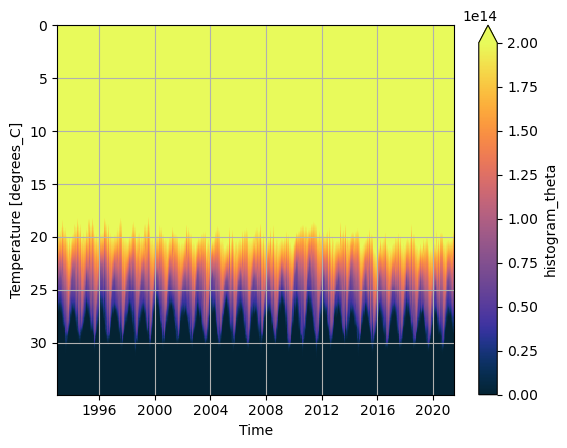

In [18]:
V.transpose().plot(yincrease=False, robust=True, cmap=cmocean.cm.thermal, vmax=2e14)
plt.grid();

In [7]:
V[0]

NameError: name 'V' is not defined

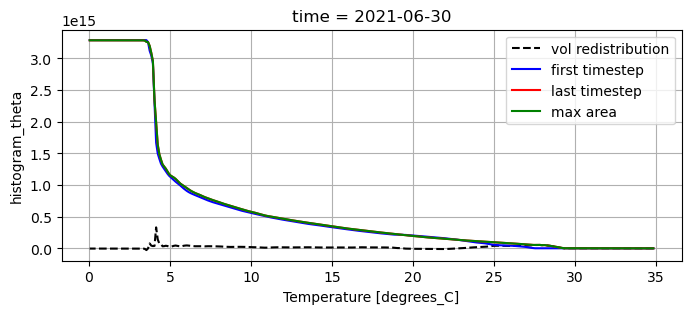

In [19]:
plt.figure(figsize=(8,3))
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
V[0].plot(label='first timestep', color='b')
V[-1].plot(label='last timestep', color='r')
#V.sel(time='2023-08-15', method='nearest').plot(label='max area', color='green')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

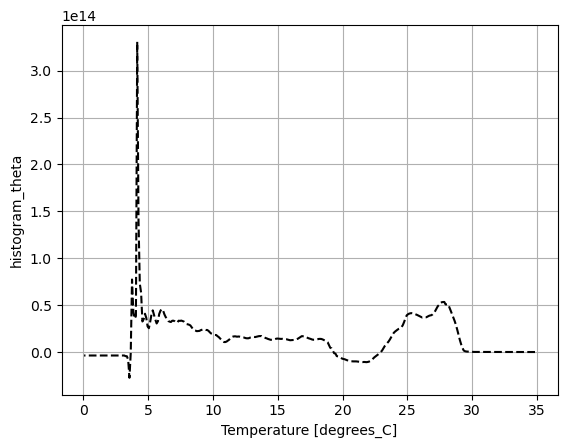

In [20]:
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
plt.grid();

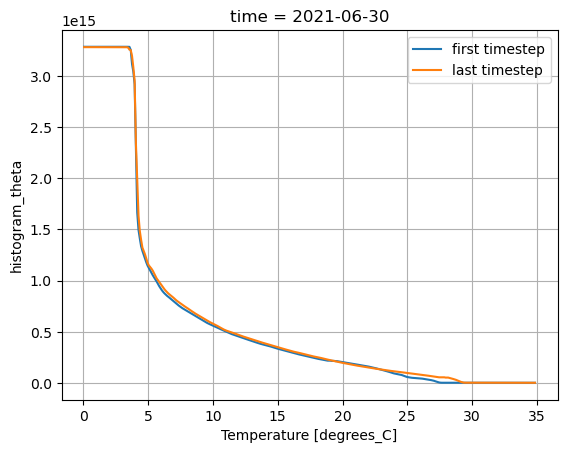

In [21]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.grid();

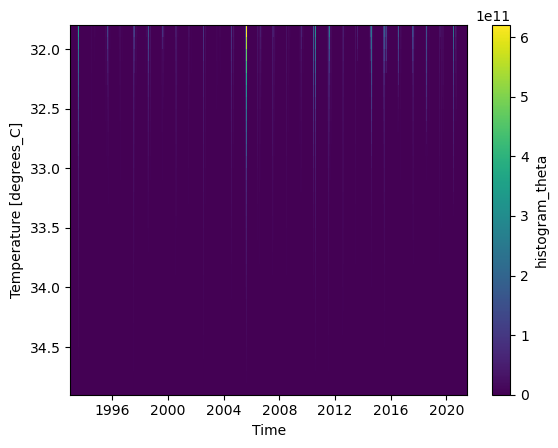

In [22]:
V.sel(theta_bin=slice(None, 31.8)).T.plot(yincrease=False)

In [23]:
delta_V = V.diff(dim='time')
dVdt = delta_V / 86400

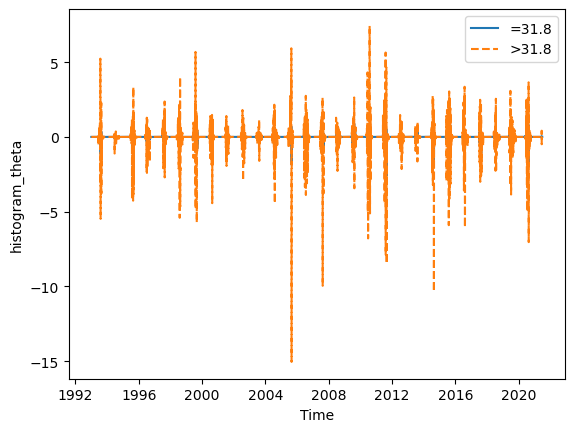

In [24]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='=31.8')
(dVdt/1e6).sel(theta_bin=slice(None, 31.8)).sum('theta_bin').plot(label='>31.8', linestyle='dashed')
plt.legend();

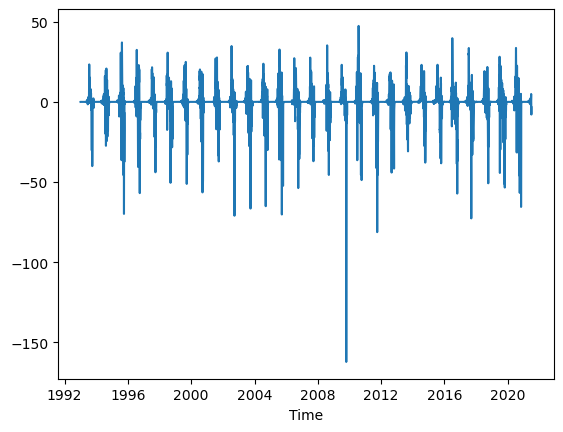

In [61]:
(dVdt/1e6).plot()

In [25]:
#Just checking (5_... nb)
V32 = tdist.sel(theta_bin=slice(31.8, None)).sum('theta_bin')

delta_V32 = V32.diff(dim='time')
dVdt32 = delta_V32 / 86400

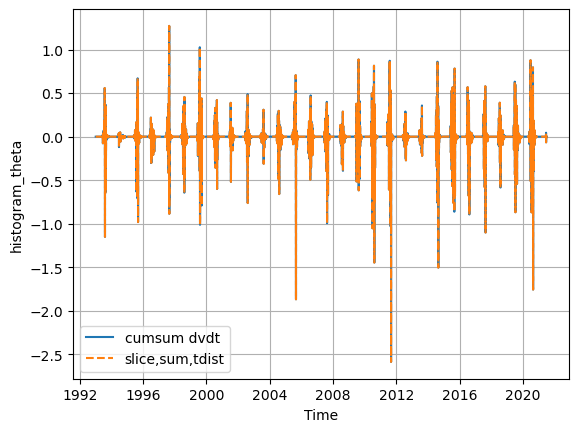

In [26]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='cumsum dvdt')
(dVdt32/1e6).plot(label='slice,sum,tdist', linestyle='dashed')
plt.legend()
plt.grid()

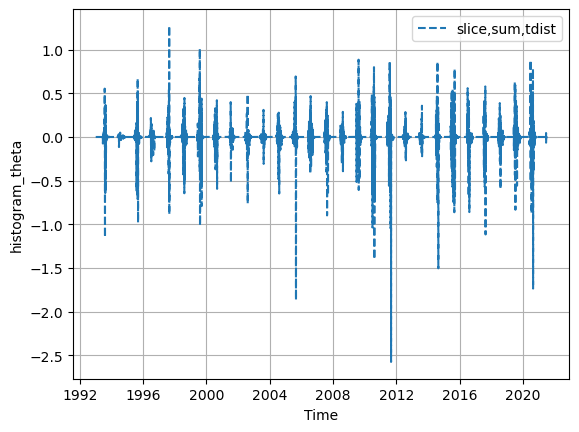

In [57]:
#(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='cumsum dvdt')
(dVdt32/1e6).plot(label='slice,sum,tdist', linestyle='dashed')
plt.legend()
plt.grid()

In [27]:
dVdt.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/dVdt_hist_method.nc')

In [62]:
dVdt.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/dVdt_where_method.nc')

In [58]:
dVdt32.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/dVdt32_hist_method.nc')

# 3) Compute RHS ($G_\Omega(\theta)$)
- where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space
- where $G$ is the temperature tendencies due to surface heat fluxes
- surface terms come from ERA5

## Create grid and area objects

In [28]:
ds_full_e = generate_grid_ds(hf, {'X':'longitude', 'Y':'latitude'})
#ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

grid_e = xgcm.Grid(ds_full_e, periodic='X')
#grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [29]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [30]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
#cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


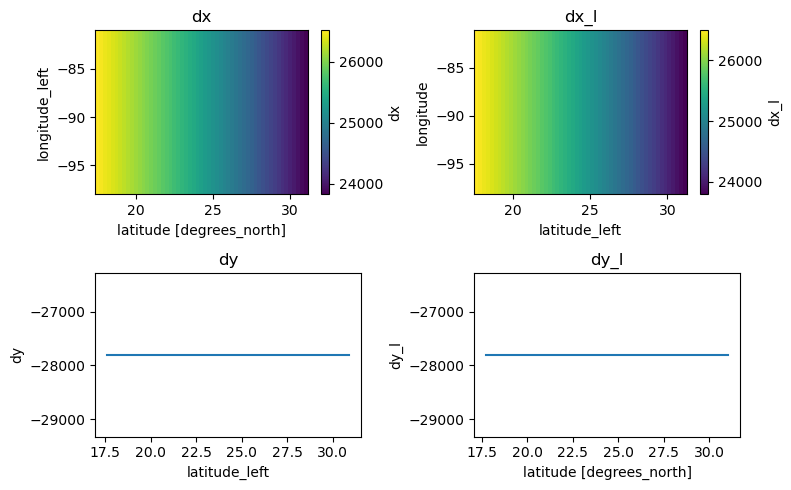

In [31]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

#### Create mask

In [32]:
mask_e = sst[0].isnull()
#mask_m = merra.TSKINWTR[0].isnull()

In [33]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

#dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
#area_m = dx_interp_m * cell_elements_m.dy_l

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [34]:
area_e

<xarray.DataArray (longitude: 69, latitude: 55)> Size: 15kB
array([[-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       ...,
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [ 4.5042598e+10,  4.5160260e+10,  4.5277061e+10, ...,
         4.9976308e+10,  5.0046685e+10,            nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

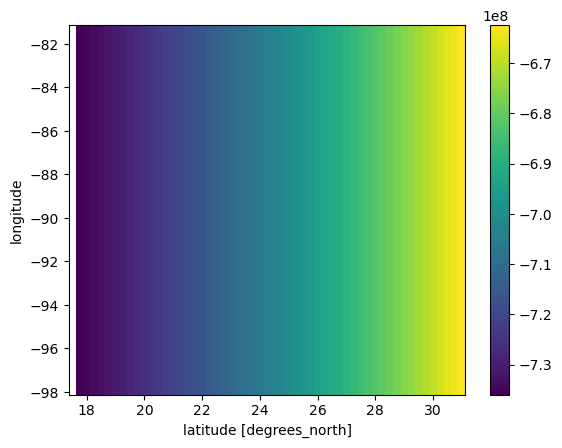

In [35]:
area_e.isel(longitude=slice(None, -1)).plot()

In [19]:
area_e.coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

In [20]:
heat_fluxes.coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

In [37]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027 #kg/m^3 #according to Harte Research Institute(https://www.harteresearch.org/sites/default/files/inline-files/3.pdf)

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted = (hf.isel(longitude=slice(None, -1)) * 
                area_e.isel(longitude=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s
#merra_weighted = (merra.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                 # area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

In [38]:
era_weighted

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 55, time: 10408, longitude: 68)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25
Data variables:
    ssr        (time, latitude, longitude) float64 311MB dask.array<chunksize=(10408, 55, 68), meta=np.ndarray>
    str        (time, latitude, longitude) float64 311MB dask.array<chunksize=(10408, 55, 68), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 311MB dask.array<chunksize=(10408, 55, 68), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 311MB dask.array<chunksize=(10408, 55, 68), meta=np.ndarray>

$$F_{PS77} = Re^{- \frac{z}{h_1}} + (1-R)e^{- \frac{z}{h_2}}$$
where $R = 0.58$, $h_1 = 0.35$ m, $h_2 = 0.23$ m (eq from Groeskamp and Iudicone 2018 GRL)

In [40]:
glorys.depth.values

array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03], dtype=float32)

In [41]:
#Create decay function for SSR penetration
#Jerlov Type 1 (upper 50m)
R = 0.68
h1 = 1.2 #m
h2 = 28 #m
z_values = np.array([0, 4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03])
z = xr.DataArray(data=z_values, dims={'depth'}, coords={'depth':z_values})
F_ps77 = R * np.exp(-z/h1) + (1-R) * np.exp(-z/h2)

#expand ssr da in z dimension then apply decay function 
ssr_Zexpanded = era_weighted.ssr.expand_dims({'depth':z}) 
ssr_z = ssr_Zexpanded * (F_ps77)

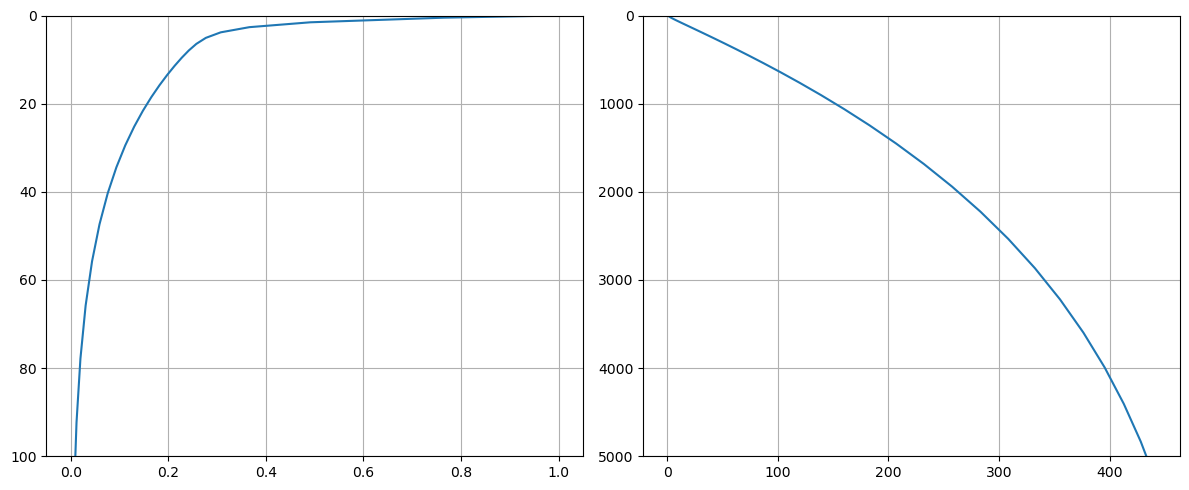

In [42]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(F_ps77, z)
ax0.set_ylim(100, 0)
ax0.grid()

ax1.plot(z.diff(dim='depth'), z.diff(dim='depth').depth)
ax1.set_ylim(5000,0)
#ax1.set_xlim(0, None)
ax1.grid()

plt.tight_layout();

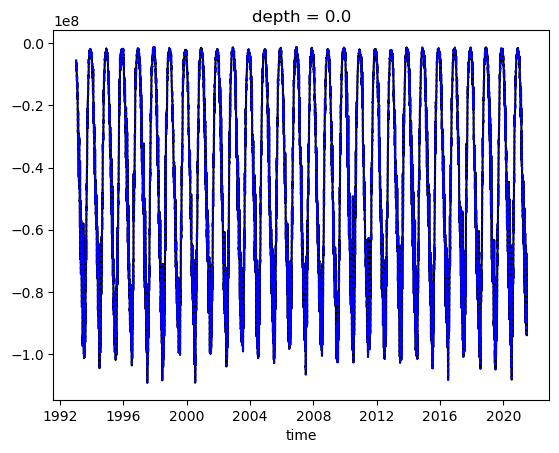

In [43]:
era_weighted.ssr.sum(['latitude', 'longitude']).plot(color='k')
ssr_z.sum(['latitude', 'longitude']).isel(depth=0).plot(color='blue', linestyle='dotted')

In [44]:
dFlx = ssr_z.diff(dim='depth')
dz = z.diff(dim='depth')
dFlxdz = - dFlx / dz

In [45]:
dFlxdz

<xarray.DataArray (depth: 49, time: 10408, latitude: 55, longitude: 68)> Size: 15GB
dask.array<truediv, shape=(49, 10408, 55, 68), dtype=float64, chunksize=(49, 10408, 55, 68), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25

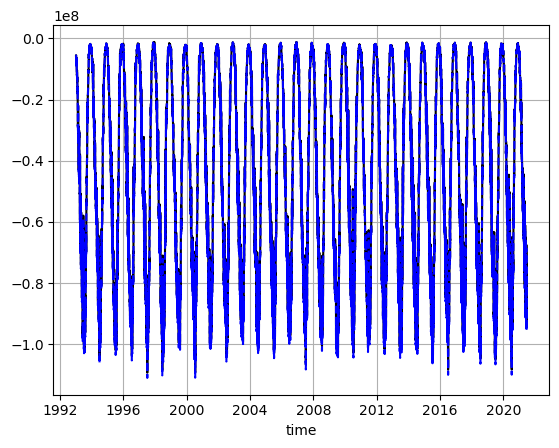

In [46]:
era_weighted.ssr.sum(['latitude', 'longitude']).plot(color='k')
dFlxdz.sum(['latitude', 'longitude', 'depth']).plot(color='blue', linestyle='--')
plt.grid()

In [47]:
sst_g.shape

(10408, 49, 163, 205)

In [48]:
dFlxdz.transpose('time', 'depth', 'latitude', 'longitude').shape

(10408, 49, 55, 68)

In [49]:
delta_theta = 0.1
theta_bins = np.arange(0, 35, delta_theta)

def hist_func(sst, ds, lat, lon, variable):
    hist = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=ds[variable].fillna(0.),
                    dim=[lon, lat]) / delta_theta
    return hist #m^3/s (Sv)

def hist_func_ssrz(sst, da, lat, lon, depth):
    hist_srp = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=da.fillna(0.),
                    dim=[lon, lat, depth]) / delta_theta
    return hist_srp #m^3/s (Sv)


In [50]:
list(era_weighted.data_vars)[1:]

['str', 'sshf', 'slhf']

In [51]:
sst.isel(longitude=slice(None, -1)).coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [52]:
era_weighted.coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25

In [56]:
dFlxdz.coords

Coordinates:
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25

In [58]:
mask_e.isel(longitude=slice(None, -1)).coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25
    time       datetime64[ns] 8B 1993-01-01

In [53]:
era_hist = xr.merge([hist_func(sst.isel(longitude=slice(None, -1)), 
                               era_weighted.where(~mask_e.isel(longitude=slice(None, -1))),
                               'latitude', 'longitude', var).rename('omega_'+var) 
                     for var in list(era_weighted)[1:]])
#sst_m = merra.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).where(~mask_m)
#merra_hist = xr.merge([hist_func(sst_m, 
#                                 merra_weighted.where(~mask_m),
#                                 'lat', 'lon', var).rename('omega_'+var)
#                      for var in list(merra_weighted)[:-1]])

In [59]:
ssrz_hist = hist_func_ssrz(sst.isel(longitude=slice(None, -1)).expand_dims({'depth':dFlxdz.depth}),
                           dFlxdz.transpose('time', 'depth', 'latitude', 
                                            'longitude').where(~mask_e.isel(longitude=slice(None, -1))),
                           'latitude', 'longitude', 'depth').rename('omega_ssrz')

In [62]:
#merge new ssr da into era_hist and run clim calculations for uploading new clim datasets for fig 3 in manuscript
era_hist['omega_ssrz'] = ssrz_hist

In [63]:
era_hist

<xarray.Dataset> Size: 116MB
Dimensions:     (time: 10408, theta_bin: 349)
Coordinates:
  * time        (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin   (theta_bin) float64 3kB 0.05 0.15 0.25 ... 34.65 34.75 34.85
Data variables:
    omega_str   (time, theta_bin) float64 29MB dask.array<chunksize=(10408, 349), meta=np.ndarray>
    omega_sshf  (time, theta_bin) float64 29MB dask.array<chunksize=(10408, 349), meta=np.ndarray>
    omega_slhf  (time, theta_bin) float64 29MB dask.array<chunksize=(10408, 349), meta=np.ndarray>
    omega_ssrz  (time, theta_bin) float64 29MB dask.array<chunksize=(10408, 349), meta=np.ndarray>

<Figure size 2500x500 with 0 Axes>

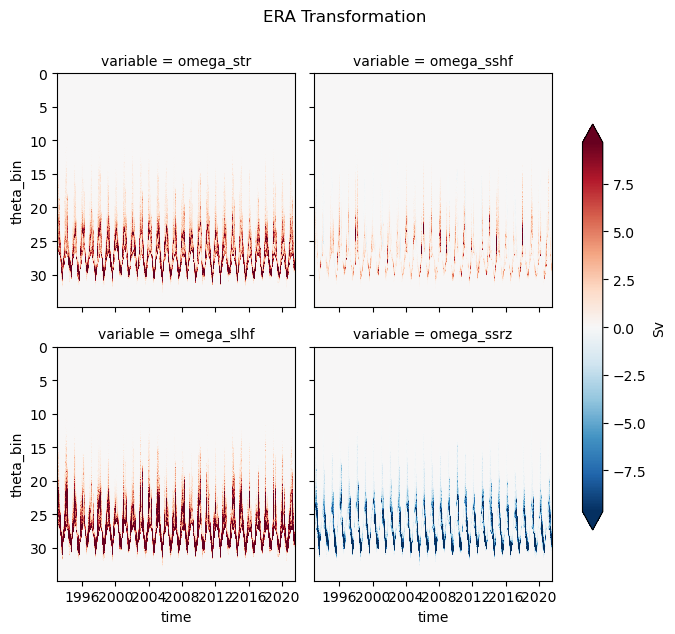

In [64]:
plt.figure(figsize=(25,5))
(era_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('ERA Transformation', y=1.05);

### Save histogram ds

In [65]:
era_hist.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/era_hist.nc')

# 4) Budget!

In [66]:
lhs = xr.open_dataset('budget-terms/dVdt_hist_method.nc')
era_hist = xr.open_dataset('budget-terms/era_hist.nc')
rhs = era_hist.isel(time=slice(1, None))

In [67]:
lhs

<xarray.Dataset> Size: 15MB
Dimensions:          (time: 10407, theta_bin: 349)
Coordinates:
  * time             (time) datetime64[ns] 83kB 1993-01-02 ... 2021-06-30
  * theta_bin        (theta_bin) float64 3kB 34.85 34.75 34.65 ... 0.15 0.05
Data variables:
    histogram_theta  (time, theta_bin) float32 15MB ...

In [68]:
rhs

<xarray.Dataset> Size: 116MB
Dimensions:     (time: 10407, theta_bin: 349)
Coordinates:
  * time        (time) datetime64[ns] 83kB 1993-01-02 1993-01-03 ... 2021-06-30
  * theta_bin   (theta_bin) float64 3kB 0.05 0.15 0.25 ... 34.65 34.75 34.85
Data variables:
    omega_str   (time, theta_bin) float64 29MB ...
    omega_sshf  (time, theta_bin) float64 29MB ...
    omega_slhf  (time, theta_bin) float64 29MB ...
    omega_ssrz  (time, theta_bin) float64 29MB ...

In [71]:
isotherm = 31.8
one_plt_era = - (rhs.sel(theta_bin=isotherm, method='nearest') / 1e6)
one_plt_dVdt = (lhs.histogram_theta.sel(theta_bin=isotherm, method='nearest') / 1e6)
residual = one_plt_dVdt - one_plt_era.to_array().sum('variable')

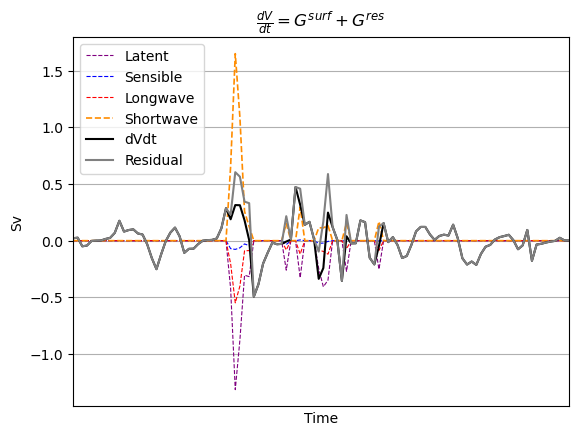

In [72]:
time_slice = dict(time=slice('2006-06-15', '2006-09-30'))
ticks = [one_plt_dVdt.time[i].values for i in [164, 180, 194, 211, 225, 242, 256]]
tick_labels = ['June 15', 'July', 'July 15', 'Aug', 'Aug 15', 'Sept', 'Sept 15']
ax = plt.axes() 

one_plt_era.omega_slhf.sel(**time_slice).plot(label='Latent', color='purple', linestyle='dashed', linewidth=0.8)
one_plt_era.omega_sshf.sel(**time_slice).plot(label='Sensible', color='blue', linestyle='dashed', linewidth=0.8)
one_plt_era.omega_str.sel(**time_slice).plot(label='Longwave', color='red', linestyle='dashed', linewidth=0.8)
one_plt_era.omega_ssrz.sel(**time_slice).plot(label='Shortwave', color='darkorange', linestyle='dashed', linewidth=1.2)
one_plt_dVdt.sel(**time_slice).plot(label='dVdt', color='k')
residual.sel(**time_slice).plot(label='Residual', color='grey')
plt.legend(loc='upper left')
#plt.ylim(-30, 60)
plt.ylabel('Sv')
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
plt.xlabel('Time')
plt.grid()
t1 = dict(time='2006-06-15', method='nearest')
t2 = dict(time='2006-09-30', method='nearest')
plt.xlim(one_plt_era.time.sel(**t1), one_plt_era.time.sel(**t2))
plt.title(r'$\frac{dV}{dt} = G^{surf} + G^{res}$');
#plt.savefig('paper-figs/era/budget.pdf')
#plt.suptitle('ERA');